In [349]:
import pandas as pd

news = pd.read_csv('news_articles.csv')
news = news[news['language'] == 'english']

news.head()

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


Remove unimportant columns and add a length column. Typically articles below a certain length threshold are very
unlikely to actually be articles. Let's remove observations with text below a certain length.

In [350]:
# remove all columns except publication data, title, text, type, and label
news = news[['published', 'title', 'text', 'type', 'label']].dropna().reset_index(drop=True)

# add title to text of article
news['text'] = news['title'] + "\n\n" + news['text']

# add a length feature
news['length']  = news['text'].str.len()

# remove observation with text below a certain length
news = news.loc[news['length'] >= 500]

og_news = news.copy()

news.head()

,published,title,text,type,label,length
0,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,muslims busted they stole millions in govt ben...,bias,Real,545
1,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,re why did attorney general loretta lynch plea...,bias,Real,1779
2,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,breaking weiner cooperating with fbi on hillar...,bias,Real,1392
4,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,fantastic trumps point plan to reform healthc...,bias,Real,2139
5,2016-11-02T16:31:28.550+02:00,hillary goes absolutely berserk on protester a...,hillary goes absolutely berserk on protester a...,bias,Real,1221


Create histogram to examine number of articles with 'Real' vs 'Fake' labels.

In [351]:
import plotly.express as px

fig = px.histogram(news, x="label")
fig.show()

Examine distribution or article types.

In [352]:
fig = px.histogram(news, x="type")
fig.show()

Evaluate distribution of article lengths.

In [353]:
fig = px.histogram(news, x="length")
fig.show()

In [354]:
fig = px.histogram(news, x="length", color="label")
fig.show()

In [355]:
# Load the regular expression library
import re
# Remove punctuation
news['title_processed'] = \
news['title'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert text to lowercase
news['title_processed'] = \
news['title_processed'].map(lambda x: x.lower())
# Print out the first rows of news
news['title_processed'].head()

0    muslims busted they stole millions in govt ben...
1    re why did attorney general loretta lynch plea...
2    breaking weiner cooperating with fbi on hillar...
4    fantastic trumps  point plan to reform healthc...
5    hillary goes absolutely berserk on protester a...
Name: title_processed, dtype: object

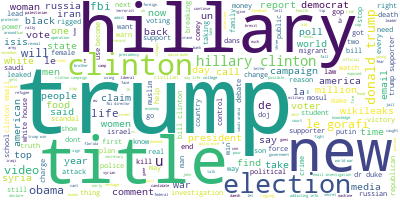

In [356]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(news['title_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [357]:
#Prepare for LDA analysis
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = news.title_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['muslims', 'busted', 'stole', 'millions', 'govt', 'benefits']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [358]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [359]:
#LDA
from pprint import pprint
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

In [360]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.021*"trump" + 0.017*"clinton" + 0.006*"donald" + 0.004*"video" + '
  '0.004*"hillary" + 0.004*"life" + 0.004*"us" + 0.004*"duke" + 0.004*"obama" '
  '+ 0.004*"campaign"'),
 (1,
  '0.019*"title" + 0.011*"clinton" + 0.010*"hillary" + 0.006*"election" + '
  '0.005*"fbi" + 0.005*"trump" + 0.004*"new" + 0.004*"us" + 0.004*"email" + '
  '0.004*"comey"'),
 (2,
  '0.014*"trump" + 0.008*"election" + 0.007*"us" + 0.007*"le" + 0.006*"gorafi" '
  '+ 0.006*"donald" + 0.004*"hillarys" + 0.004*"new" + 0.003*"isis" + '
  '0.003*"news"'),
 (3,
  '0.027*"hillary" + 0.015*"trump" + 0.009*"title" + 0.008*"clinton" + '
  '0.006*"fbi" + 0.005*"obama" + 0.005*"le" + 0.005*"video" + 0.004*"gorafi" + '
  '0.004*"clintons"')]


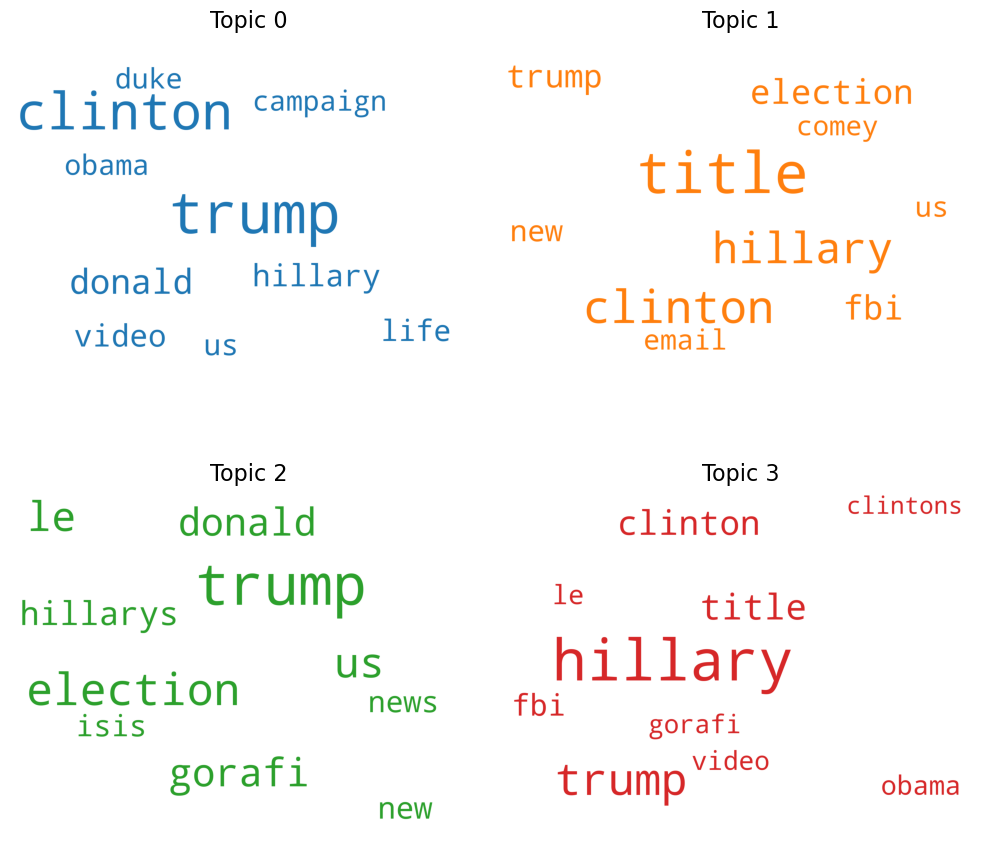

In [361]:
# Visualize the topics
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [362]:
og_news = og_news.sample(10)

In [363]:
text_list = list(og_news['text'])

with open("sample_articles.txt", 'w') as f:
    for line in text_list:
        f.write(f"NEXT ARTICLE:\n\n{line}\n\n\n")